In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from graphcast import losses

In [2]:
import graphufs
plt.style.use("graphufs.plotstyle")

/contrib2/Tim.Smith/graph-ufs/graphufs/training.py:59: UserWarning: Import failed for either mpi4py or mpi4jax.
  warnings.warn("Import failed for either mpi4py or mpi4jax.")


In [29]:
rds = xr.open_zarr(
    "gs://noaa-ufs-gefsv13replay/ufs-hr1/0.25-degree/03h-freq/zarr/fv3.zarr",
    storage_options={"token": "anon"},
)
rds = rds.rename({
    "pfull": "level",
    "grid_yt": "lat",
    "grid_xt": "lon",
})
rds.attrs["label"] = "Replay"

In [30]:
%%time
sds = xr.open_zarr(
    "gs://noaa-ufs-gefsv13replay/ufs-hr1/0.25-degree-subsampled/03h-freq/zarr/fv3.zarr",
    storage_options={"token": "anon"},
)
sds = sds.rename({
    "pfull": "level",
    "grid_yt": "lat",
    "grid_xt": "lon",
})
sds.attrs["label"] = "Replay Subsampled"

CPU times: user 3.71 s, sys: 1.43 s, total: 5.15 s
Wall time: 6.74 s


In [31]:
%%time
era = xr.open_zarr(
    "gs://weatherbench2/datasets/era5/1959-2023_01_10-wb13-6h-1440x721_with_derived_variables.zarr",
    storage_options={"token":"anon"},
)
era = era.rename({
    "latitude": "lat",
    "longitude": "lon",
})
era.attrs["label"] = "ERA5"

CPU times: user 1.12 s, sys: 411 ms, total: 1.53 s
Wall time: 2.19 s


In [32]:
for xds in [era, rds, sds]:
    lat = xds.coords["lat"]
    print("with poles: ", np.any(np.isclose(np.abs(lat), 90.)))

with poles:  True
with poles:  False
with poles:  False


In [39]:
era["lat_weights"] = xr.DataArray(
    losses._weight_for_latitude_vector_with_poles(era.coords["lat"]),
    coords=era.lat.coords,
)
era["lat_weights"] /= era.lat_weights.mean()
era = era.set_coords("lat_weights")

In [43]:
for xds in [rds, sds]:
    xds["lat_weights"] = xr.DataArray(
        losses._unequal_weight_for_latitude_vector_without_poles(xds.coords["lat"]),
        coords=xds.lat.coords,
    )
    xds["lat_weights"] /= xds.lat_weights.mean()
    xds = xds.set_coords("lat_weights")

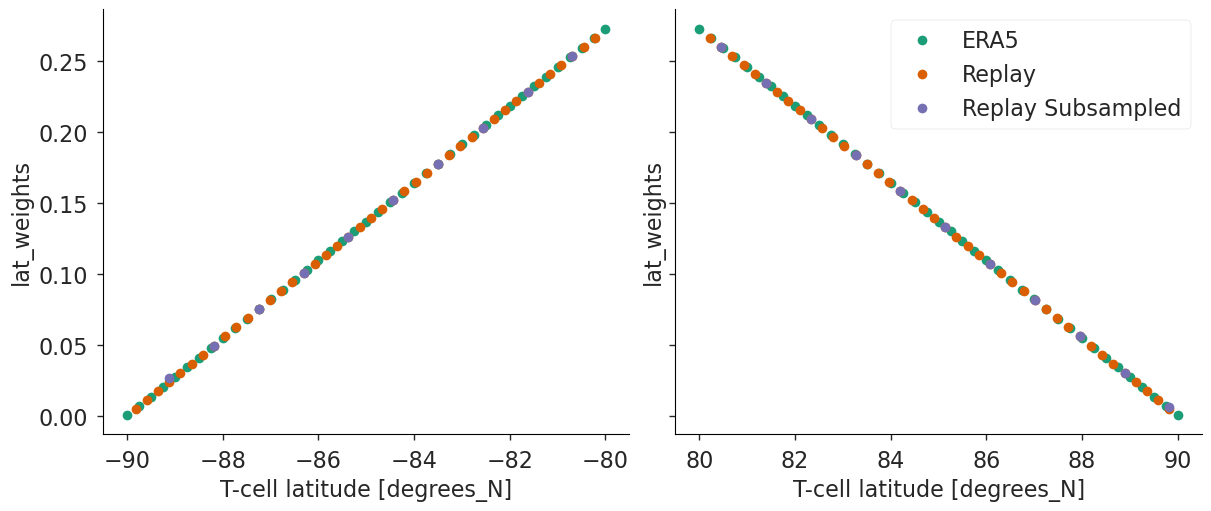

In [83]:
fig, axs = plt.subplots(1, 2, figsize=(12,5), constrained_layout=True, sharey=True)

for latslice, ax in zip([slice(-80, -90), slice(90, 80)], axs):

    for xds in [era,rds, sds]:
        xds.lat_weights.sel(
            lat=latslice,
        ).plot(
            x="lat",
            marker='o',
            ax=ax,
            label=xds.label,
            linestyle='',
        )
ax.legend()

In [72]:
lat = sds.lat
dLatC = np.deg2rad(lat).diff("lat").values
bds = np.deg2rad(lat).values[:-1] + dLatC/2
left = [np.deg2rad(rds.lat.values[1])]
right = [np.deg2rad(rds.lat.values[-1])]
bds = np.concatenate([left, bds, right])
sds["new_weights"] = xr.DataArray(
    np.abs(np.sin(bds[:-1]) - np.sin(bds[1:])),
    coords=lat.coords,
)
sds["new_weights"] /= sds.new_weights.mean()

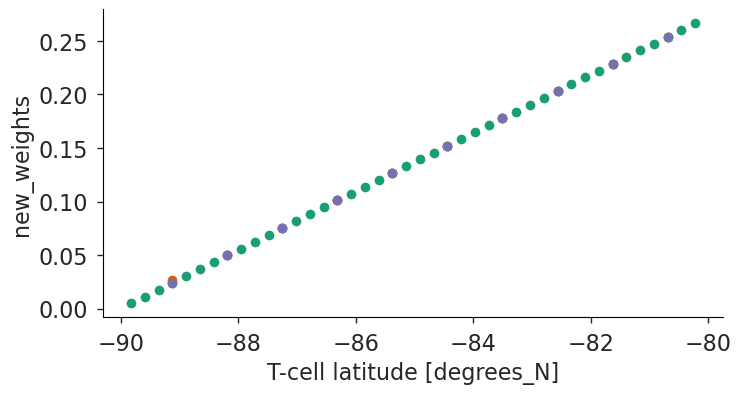

In [66]:
fig, ax = plt.subplots(figsize=(8,4))

for xds in [rds, sds]:
    xds.lat_weights.sel(
        lat=slice(-80, -90),
    ).plot(
        x="lat",
        marker='o',
        ax=ax,
        label=xds.label,
        linestyle='',
    )
sds.new_weights.sel(lat=slice(-80, -90)).plot(
    x="lat",
    marker='o',
    linestyle="",
    ax=ax,
)

In [70]:
kw = dict(
    x="lat",
    marker='o',
    linestyle="",
)    

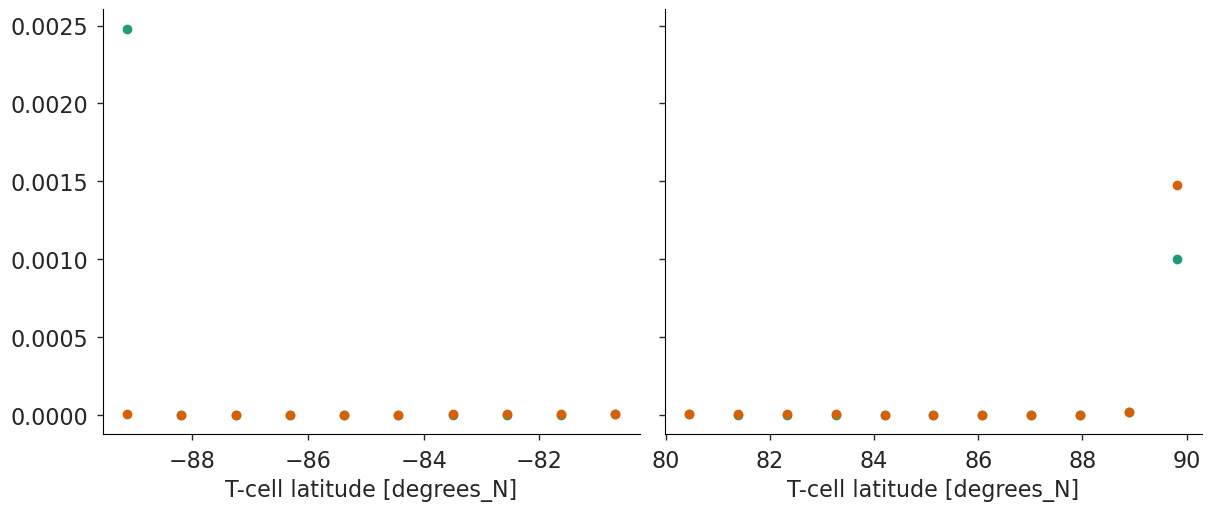

In [71]:
fig, axs = plt.subplots(1, 2, figsize=(12,5), constrained_layout=True, sharey=True)

for latslice, ax in zip([slice(-80, -90), slice(90, 80)], axs):
    np.abs(sds.lat_weights - rds.lat_weights).sel(lat=latslice).plot(ax=ax, **kw)
    np.abs(sds.new_weights - rds.lat_weights).sel(lat=latslice).plot(ax=ax, **kw)

In [75]:
def get_hweights(lat, lon):
    r0 = 6_378_000
    dx = r0*np.cos(np.deg2rad(lat))*np.deg2rad(lon).diff("lon")
    dy = r0*np.deg2rad(lat).diff("lat")
    return dx, dy
    

In [76]:
dx, dy = get_hweights(rds.lat, rds.lon)

In [78]:
dy

<xarray.DataArray 'lat' (lat: 767)> Size: 6kB
array([-25854.36483886, -26007.04883673, -26041.54666432, -26054.63250485,
       -26060.96477488, -26064.50361052, -26066.68000548, -26068.11329519,
       -26069.10701064, -26069.82414126, -26070.35857307, -26070.76748589,
       -26071.08732009, -26071.3421904 , -26071.54857058, -26071.718025  ,
       -26071.85886521, -26071.97718917, -26072.07755289, -26072.16341565,
       -26072.23744226, -26072.30171238, -26072.35786813, -26072.40722017,
       -26072.45082483, -26072.4895411 , -26072.52407327, -26072.55500326,
       -26072.58281516, -26072.60791447, -26072.63064278, -26072.65128959,
       -26072.67010153, -26072.68728973, -26072.70303583, -26072.71749674,
       -26072.73080862, -26072.74309003, -26072.75444466, -26072.76496345,
       -26072.77472648, -26072.78380443, -26072.79225993, -26072.80014862,
       -26072.80752003, -26072.81441842, -26072.8208834 , -26072.82695054,
       -26072.83265181, -26072.83801604, -26072.8430693 , -26072.84783513,
       -26072.85233495, -26072.85658817, -26072.86061249, -26072.86442404,
       -26072.86803755, -26072.87146652, -26072.87472327, -26072.87781917,
       -26072.88076461, -26072.8835692 , -26072.88624177, -26072.88879047,
       -26072.89122283, -26072.89354584, -26072.89576593, -26072.89788911,
       -26072.89992092, -26072.90186653, -26072.90373074, -26072.90551804,
       -26072.90723258, -26072.90887826, -26072.91045873, -26072.91197737,
       -26072.91343736, -26072.91484168, -26072.91619314, -26072.91749433,
...
       -26072.91619314, -26072.91484168, -26072.91343736, -26072.91197737,
       -26072.91045873, -26072.90887826, -26072.90723258, -26072.90551804,
       -26072.90373074, -26072.90186653, -26072.89992092, -26072.89788911,
       -26072.89576593, -26072.89354584, -26072.89122283, -26072.88879047,
       -26072.88624177, -26072.8835692 , -26072.88076461, -26072.87781917,
       -26072.87472327, -26072.87146652, -26072.86803755, -26072.86442404,
       -26072.86061249, -26072.85658817, -26072.85233495, -26072.84783513,
       -26072.8430693 , -26072.83801604, -26072.83265181, -26072.82695054,
       -26072.8208834 , -26072.81441842, -26072.80752003, -26072.80014862,
       -26072.79225993, -26072.78380443, -26072.77472648, -26072.76496345,
       -26072.75444466, -26072.74309003, -26072.73080862, -26072.71749674,
       -26072.70303583, -26072.68728973, -26072.67010153, -26072.65128959,
       -26072.63064278, -26072.60791447, -26072.58281516, -26072.55500326,
       -26072.52407327, -26072.4895411 , -26072.45082483, -26072.40722017,
       -26072.35786813, -26072.30171238, -26072.23744226, -26072.16341565,
       -26072.07755289, -26071.97718917, -26071.85886521, -26071.718025  ,
       -26071.54857058, -26071.3421904 , -26071.08732009, -26070.76748589,
       -26070.35857307, -26069.82414126, -26069.10701064, -26068.11329519,
       -26066.68000548, -26064.50361052, -26060.96477488, -26054.63250485,
       -26041.54666432, -26007.04883673, -25854.36483886])
Coordinates:
  * lat      (lat) float64 6kB 89.59 89.35 89.12 88.89 ... -89.35 -89.59 -89.82

In [53]:
rds.lat

<xarray.DataArray 'lat' (lat: 768)> Size: 6kB
array([ 89.820707,  89.588449,  89.354818, ..., -89.354818, -89.588449,
       -89.820707])
Coordinates:
  * lat      (lat) float64 6kB 89.82 89.59 89.35 89.12 ... -89.35 -89.59 -89.82
Attributes:
    cartesian_axis:  Y
    long_name:       T-cell latitude
    units:           degrees_N

In [64]:
dLatC

array([-0.0162994 , -0.01634686, -0.01634996, -0.01635085, -0.01635122,
       -0.01635141, -0.01635152, -0.01635159, -0.01635164, -0.01635168,
       -0.0163517 , -0.01635172, -0.01635173, -0.01635175, -0.01635175,
       -0.01635176, -0.01635177, -0.01635177, -0.01635178, -0.01635178,
       -0.01635178, -0.01635179, -0.01635179, -0.01635179, -0.01635179,
       -0.0163518 , -0.0163518 , -0.0163518 , -0.0163518 , -0.0163518 ,
       -0.0163518 , -0.0163518 , -0.0163518 , -0.0163518 , -0.0163518 ,
       -0.0163518 , -0.01635181, -0.01635181, -0.01635181, -0.01635181,
       -0.01635181, -0.01635181, -0.01635181, -0.01635181, -0.01635181,
       -0.01635181, -0.01635181, -0.01635181, -0.01635181, -0.01635181,
       -0.01635181, -0.01635181, -0.01635181, -0.01635181, -0.01635181,
       -0.01635181, -0.01635181, -0.01635181, -0.01635181, -0.01635181,
       -0.01635181, -0.01635181, -0.01635181, -0.01635181, -0.01635181,
       -0.01635181, -0.01635181, -0.01635181, -0.01635181, -0.01

In [63]:
np.diff(bds)

array([-0.01632313, -0.01634841, -0.0163504 , -0.01635103, -0.01635132,
       -0.01635147, -0.01635156, -0.01635162, -0.01635166, -0.01635169,
       -0.01635171, -0.01635173, -0.01635174, -0.01635175, -0.01635176,
       -0.01635177, -0.01635177, -0.01635178, -0.01635178, -0.01635178,
       -0.01635179, -0.01635179, -0.01635179, -0.01635179, -0.01635179,
       -0.0163518 , -0.0163518 , -0.0163518 , -0.0163518 , -0.0163518 ,
       -0.0163518 , -0.0163518 , -0.0163518 , -0.0163518 , -0.0163518 ,
       -0.0163518 , -0.01635181, -0.01635181, -0.01635181, -0.01635181,
       -0.01635181, -0.01635181, -0.01635181, -0.01635181, -0.01635181,
       -0.01635181, -0.01635181, -0.01635181, -0.01635181, -0.01635181,
       -0.01635181, -0.01635181, -0.01635181, -0.01635181, -0.01635181,
       -0.01635181, -0.01635181, -0.01635181, -0.01635181, -0.01635181,
       -0.01635181, -0.01635181, -0.01635181, -0.01635181, -0.01635181,
       -0.01635181, -0.01635181, -0.01635181, -0.01635181, -0.01